<a href="https://colab.research.google.com/github/hnnayy/DeepLearning/blob/main/week4/RNN_LSTM_GRU_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# RNN Models for IMDb Sentiment Analysis
# Using PyTorch and TensorFlow implementations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN, LSTM, GRU, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import gc

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

In [ ]:
# Parameters
NUM_WORDS = 40000  # Vocabulary size
MAXLEN = 400       # Maximum sequence length
BATCH_SIZE = 128
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
EPOCHS = 10


In [ ]:
# Load IMDb dataset
print("Loading IMDb dataset...")
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=NUM_WORDS)


Loading IMDb dataset...


In [ ]:
# Pad sequences
x_train = pad_sequences(x_train, maxlen=MAXLEN)
x_test = pad_sequences(x_test, maxlen=MAXLEN)

print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (25000, 400)
Test data shape: (25000, 400)


In [ ]:
# Get word index for later use in examples
word_index = imdb.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i - 3, '?') for i in text if i > 3])


In [ ]:
# Example decode
print("\nExample review:")
print(decode_review(x_train[0]))
print(f"Label: {'Positive' if y_train[0] == 1 else 'Negative'}")



Example review:
this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazin

In [ ]:
# Define evaluation function
def evaluate_model(model, x_test, y_test, model_name):
    y_pred_proba = model.predict(x_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    # Print metrics
    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.savefig(f'{model_name}_roc_curve.png')
    plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }


In [ ]:
# Visualize training history
def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()





# TensorFlow Implementation
# -------------------------



In [ ]:
results = []

In [ ]:
# 1. Simple RNN Model
def create_simple_rnn_model():
    model = Sequential([
        Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
        SimpleRNN(HIDDEN_DIM, return_sequences=True),
        SimpleRNN(HIDDEN_DIM),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
# 2. LSTM Model
def create_lstm_model():
    model = Sequential([
        Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
        Bidirectional(LSTM(HIDDEN_DIM, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(HIDDEN_DIM)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
# 3. GRU Model
def create_gru_model():
    model = Sequential([
        Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
        Bidirectional(GRU(HIDDEN_DIM, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(GRU(HIDDEN_DIM)),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

In [ ]:
# Train TensorFlow models
def train_tensorflow_models():
    # Early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

    # Split training data for validation
    val_split = 0.2
    val_samples = int(len(x_train) * val_split)
    x_val = x_train[-val_samples:]
    y_val = y_train[-val_samples:]
    x_train_partial = x_train[:-val_samples]
    y_train_partial = y_train[:-val_samples]

    models = [
        ('TF-SimpleRNN', create_simple_rnn_model()),
        ('TF-LSTM', create_lstm_model()),
        ('TF-GRU', create_gru_model())
    ]

    for model_name, model in models:
        print(f"\nTraining {model_name}...")
        start_time = time.time()

        checkpoint = ModelCheckpoint(f'{model_name}_best_model.h5', save_best_only=True)

        history = model.fit(
            x_train_partial, y_train_partial,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_data=(x_val, y_val),
            callbacks=[early_stopping, checkpoint]
        )

        training_time = time.time() - start_time
        print(f"Training time: {training_time:.2f} seconds")

        # Plot training history
        plot_history(history, model_name)

        # Evaluate model
        result = evaluate_model(model, x_test, y_test, model_name)
        result['training_time'] = training_time
        results.append(result)

        # Clear memory
        del model
        tf.keras.backend.clear_session()
        gc.collect()


# PyTorch Implementation
# ---------------------

In [ ]:
# PyTorch Dataset
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        x = torch.tensor(self.sequences[idx], dtype=torch.long)
        y = torch.tensor(self.labels[idx], dtype=torch.float)
        return x, y


In [ ]:
# Create PyTorch DataLoaders
def create_dataloaders():
    # Split training data for validation
    val_split = 0.2
    val_samples = int(len(x_train) * val_split)

    x_val = x_train[-val_samples:]
    y_val = y_train[-val_samples:]
    x_train_partial = x_train[:-val_samples]
    y_train_partial = y_train[:-val_samples]

    train_dataset = IMDbDataset(x_train_partial, y_train_partial)
    val_dataset = IMDbDataset(x_val, y_val)
    test_dataset = IMDbDataset(x_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    return train_loader, val_loader, test_loader


In [ ]:
# Define PyTorch models
class SimpleRNNModel(nn.Module):
    def __init__(self):
        super(SimpleRNNModel, self).__init__()
        self.embedding = nn.Embedding(NUM_WORDS, EMBEDDING_DIM)
        self.rnn1 = nn.RNN(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.rnn2 = nn.RNN(HIDDEN_DIM * 2, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(HIDDEN_DIM * 2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn1(x)
        out, _ = self.rnn2(out)
        out = out[:, -1, :]  # Take the last output
        out = self.dropout(out)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.relu(self.fc2(out))
        out = self.sigmoid(self.fc3(out))
        return out.squeeze()


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(NUM_WORDS, EMBEDDING_DIM)
        self.lstm1 = nn.LSTM(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.3)
        self.lstm2 = nn.LSTM(HIDDEN_DIM * 2, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(HIDDEN_DIM * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.lstm1(x)
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = out[:, -1, :]  # Take the last output
        out = self.dropout2(out)
        out = self.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out.squeeze()


In [ ]:
class GRUModel(nn.Module):
    def __init__(self):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(NUM_WORDS, EMBEDDING_DIM)
        self.gru1 = nn.GRU(EMBEDDING_DIM, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.3)
        self.gru2 = nn.GRU(HIDDEN_DIM * 2, HIDDEN_DIM, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(HIDDEN_DIM * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.gru1(x)
        out = self.dropout1(out)
        out, _ = self.gru2(out)
        out = out[:, -1, :]  # Take the last output
        out = self.dropout2(out)
        out = self.relu(self.fc1(out))
        out = self.dropout2(out)
        out = self.relu(self.fc2(out))
        out = self.relu(self.fc3(out))
        out = self.sigmoid(self.fc4(out))
        return out.squeeze()

In [ ]:
# Training function for PyTorch models
def train_pytorch_model(model, train_loader, val_loader, model_name, epochs=EPOCHS):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model.to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters())

    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = total_loss / len(train_loader)
        train_accuracy = correct / total
        train_losses.append(avg_train_loss)
        train_accs.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        val_losses.append(avg_val_loss)
        val_accs.append(val_accuracy)

        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f'{model_name}_best_model.pt')

    training_time = time.time() - start_time
    print(f"Training time: {training_time:.2f} seconds")

    # Load best model
    model.load_state_dict(torch.load(f'{model_name}_best_model.pt'))

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{model_name}_training_history.png')
    plt.show()

    return model, training_time

In [ ]:
# Evaluation function for PyTorch models
def evaluate_pytorch_model(model, test_loader, model_name):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_preds = []
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()

            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    auc = roc_auc_score(all_labels, all_probs)

    # Print metrics
    print(f"\n{model_name} Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['Negative', 'Positive'],
               yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(f'{model_name}_confusion_matrix.png')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.savefig(f'{model_name}_roc_curve.png')
    plt.show()

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

In [ ]:
# Train PyTorch models
def train_pytorch_models():
    train_loader, val_loader, test_loader = create_dataloaders()

    models = [
        ('PT-SimpleRNN', SimpleRNNModel()),
        ('PT-LSTM', LSTMModel()),
        ('PT-GRU', GRUModel())
    ]

    for model_name, model in models:
        print(f"\nTraining {model_name}...")
        model, training_time = train_pytorch_model(model, train_loader, val_loader, model_name)

        # Evaluate model
        result = evaluate_pytorch_model(model, test_loader, model_name)
        result['training_time'] = training_time
        results.append(result)

        # Clear memory
        del model
        torch.cuda.empty_cache() if torch.cuda.is_available() else None
        gc.collect()


In [ ]:
# Compare and visualize results
def compare_models():
    df_results = pd.DataFrame(results)

    # Plot metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 3, i+1)
        sns.barplot(x='model_name', y=metric, data=df_results)
        plt.title(f'{metric.capitalize()} Comparison')
        plt.xticks(rotation=45)
        plt.tight_layout()

    plt.savefig('metrics_comparison.png')
    plt.show()

    # Plot training time comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(x='model_name', y='training_time', data=df_results)
    plt.title('Training Time Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig('training_time_comparison.png')
    plt.show()

    # Create comparison table
    print("\nModel Comparison:")
    print(df_results.to_string(index=False))

    # Save results to CSV
    df_results.to_csv('model_comparison_results.csv', index=False)

    return df_results


In [ ]:
# For running each part separately
def run_tensorflow_part():
    print("Starting TensorFlow models training...")
    train_tensorflow_models()
    print("TensorFlow training completed!")


In [ ]:
def run_pytorch_part():
    print("Starting PyTorch models training...")
    train_pytorch_models()
    print("PyTorch training completed!")

In [ ]:
def run_comparison_part():
    print("Comparing models...")
    results_df = compare_models()
    print("Comparison completed!")


Starting TensorFlow models training...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_6 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


Training TF-SimpleRNN...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.4932 - loss: 0.7029

157/157 ━━━━━━━━━━━━━━━━━━━━ 20s 96ms/step - accuracy: 0.4932 - loss: 0.7028 - val_accuracy: 0.5062 - val_loss: 0.6931
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5040 - loss: 0.6934

157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.5062 - val_loss: 0.6929
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 11s 70ms/step - accuracy: 0.4971 - loss: 0.6932 - val_accuracy: 0.4938 - val_loss: 0.6932
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.4943 - loss: 0.6932 - val_accuracy: 0.4938 - val_loss: 0.6932
Training time: 76.62 seconds


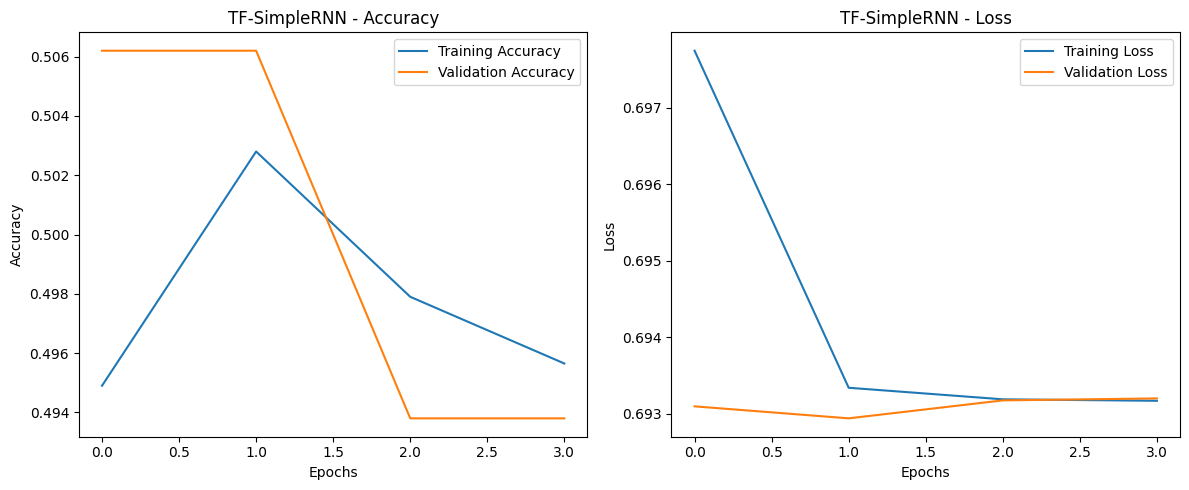

782/782 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



TF-SimpleRNN Evaluation Metrics:
Accuracy: 0.5000
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
AUC: 0.5855


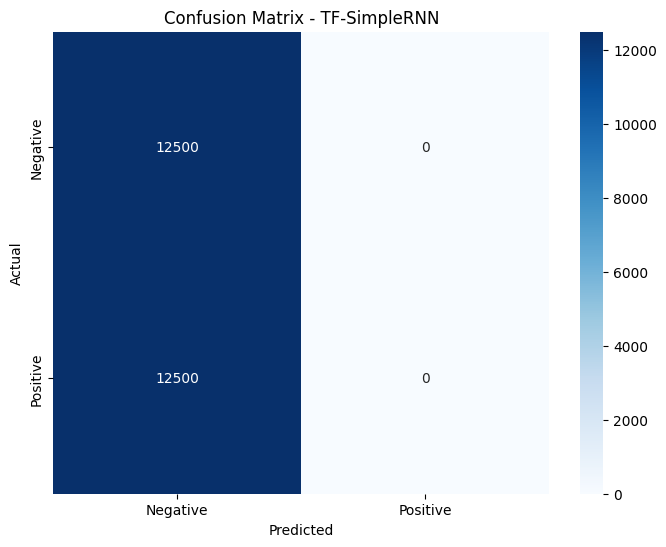

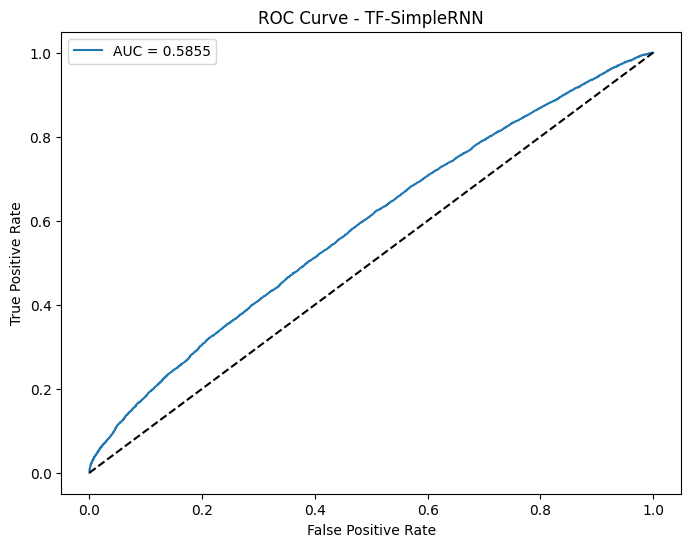


Training TF-LSTM...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6280 - loss: 0.6094

157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 155ms/step - accuracy: 0.6287 - loss: 0.6089 - val_accuracy: 0.8300 - val_loss: 0.3987
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8771 - loss: 0.3109

157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 153ms/step - accuracy: 0.8772 - loss: 0.3108 - val_accuracy: 0.8388 - val_loss: 0.3697
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.9311 - loss: 0.1986 - val_accuracy: 0.8650 - val_loss: 0.3731
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 24s 153ms/step - accuracy: 0.9531 - loss: 0.1293 - val_accuracy: 0.8634 - val_loss: 0.4147
Training time: 118.29 seconds


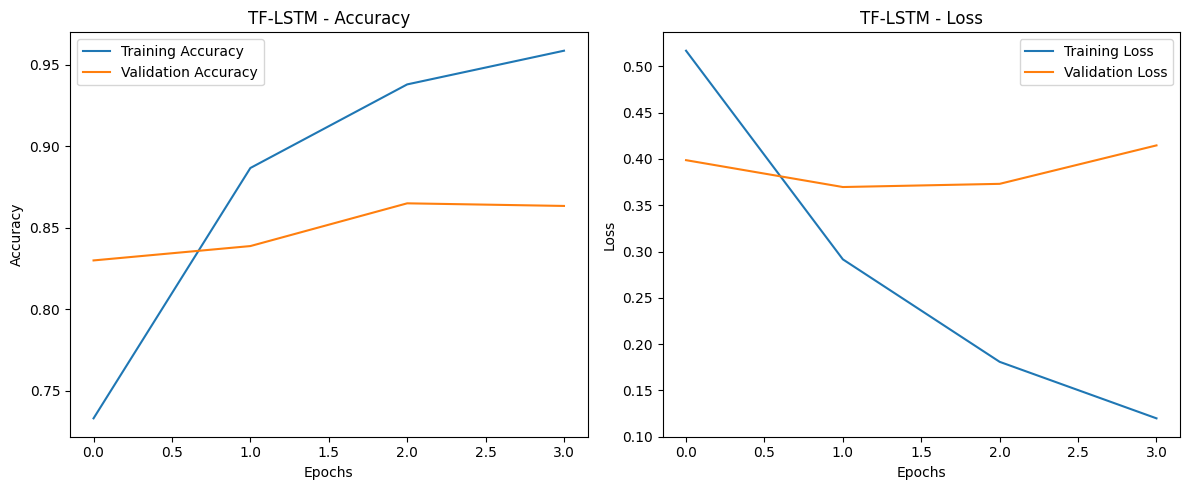

782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step

TF-LSTM Evaluation Metrics:
Accuracy: 0.8400
Precision: 0.8371
Recall: 0.8442
F1 Score: 0.8406
AUC: 0.9189


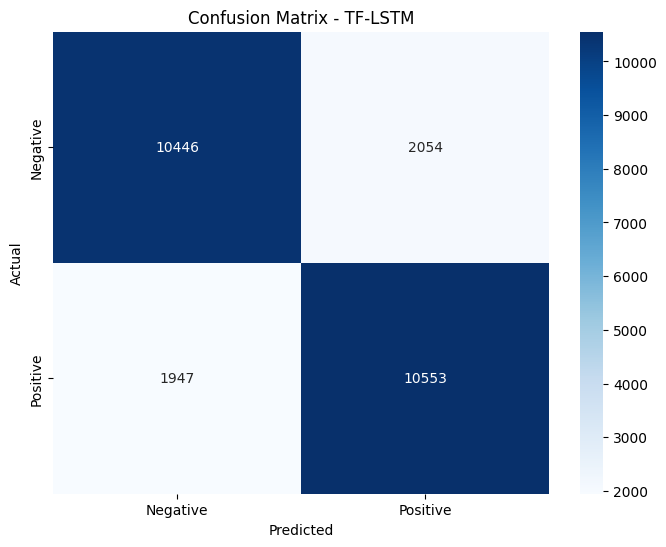

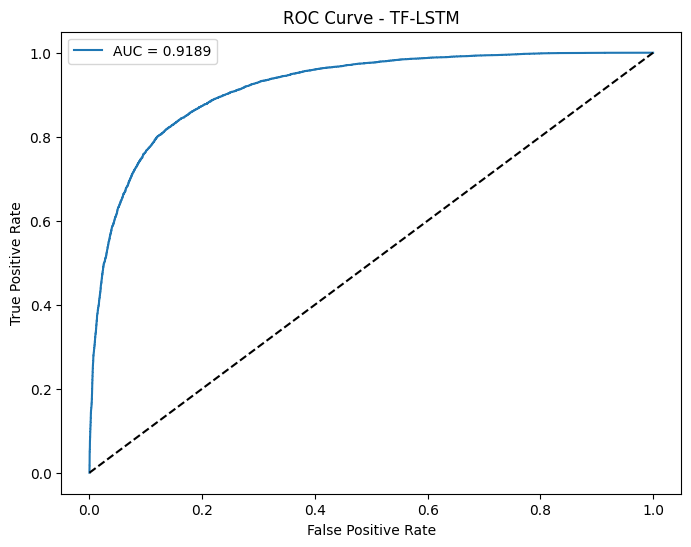


Training TF-GRU...
Epoch 1/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5922 - loss: 0.6320

157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.5929 - loss: 0.6314 - val_accuracy: 0.8506 - val_loss: 0.3502
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 40s 139ms/step - accuracy: 0.8830 - loss: 0.3058 - val_accuracy: 0.8468 - val_loss: 0.4114
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step - accuracy: 0.9389 - loss: 0.1818 - val_accuracy: 0.8446 - val_loss: 0.3791
Training time: 89.05 seconds


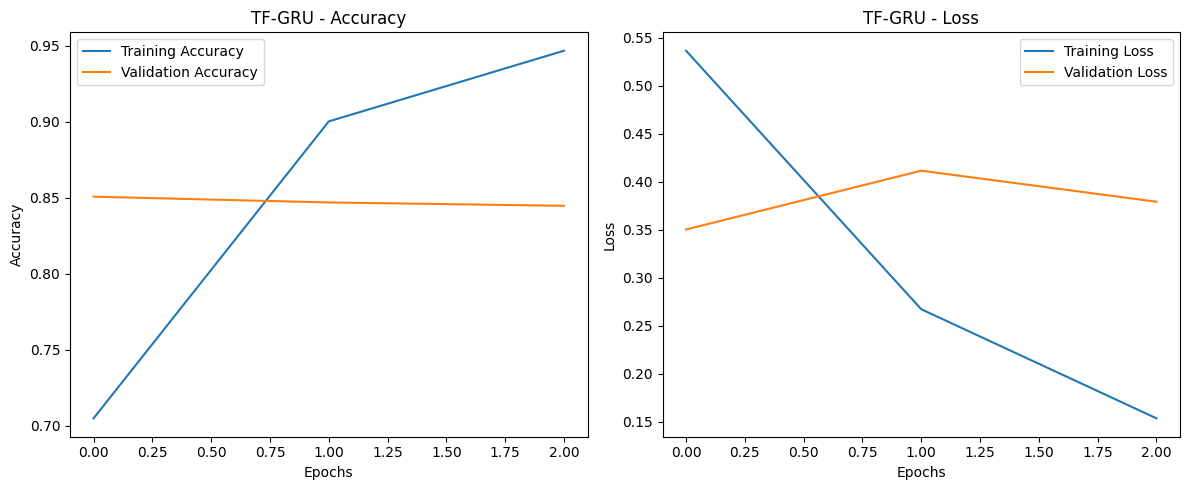

782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 23ms/step

TF-GRU Evaluation Metrics:
Accuracy: 0.8447
Precision: 0.8167
Recall: 0.8890
F1 Score: 0.8513
AUC: 0.9251


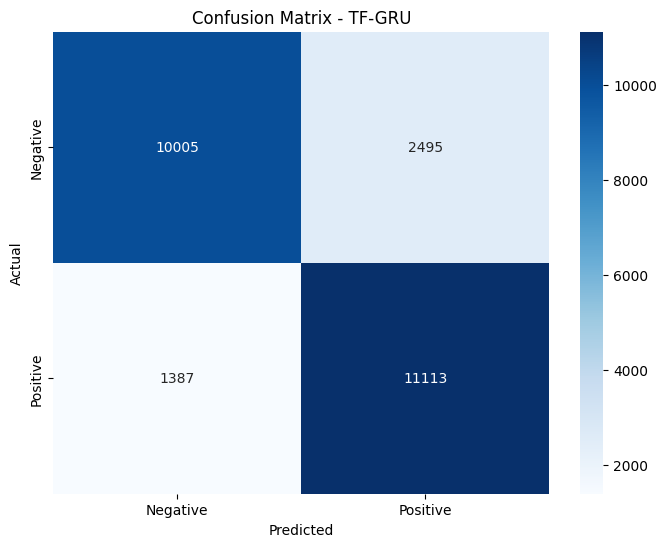

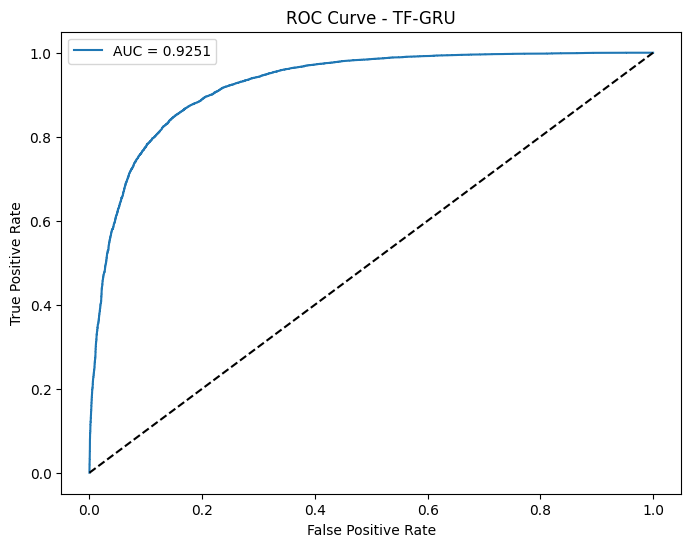

TensorFlow training completed!


In [ ]:
run_tensorflow_part()

Starting PyTorch models training...

Training PT-SimpleRNN...
Using device: cuda
Epoch 1/10, Train Loss: 0.6696, Train Acc: 0.5805, Val Loss: 0.6447, Val Acc: 0.6216
Epoch 2/10, Train Loss: 0.6052, Train Acc: 0.6762, Val Loss: 0.6270, Val Acc: 0.6418
Epoch 3/10, Train Loss: 0.6529, Train Acc: 0.6080, Val Loss: 0.6373, Val Acc: 0.6396
Epoch 4/10, Train Loss: 0.6397, Train Acc: 0.6244, Val Loss: 0.6432, Val Acc: 0.6094
Epoch 5/10, Train Loss: 0.5947, Train Acc: 0.6732, Val Loss: 0.5957, Val Acc: 0.6662
Epoch 6/10, Train Loss: 0.5413, Train Acc: 0.7279, Val Loss: 0.5795, Val Acc: 0.7092
Epoch 7/10, Train Loss: 0.4857, Train Acc: 0.7715, Val Loss: 0.6268, Val Acc: 0.6410
Epoch 8/10, Train Loss: 0.4897, Train Acc: 0.7621, Val Loss: 0.5819, Val Acc: 0.7178
Epoch 9/10, Train Loss: 0.4470, Train Acc: 0.8008, Val Loss: 0.5522, Val Acc: 0.7492
Epoch 10/10, Train Loss: 0.3829, Train Acc: 0.8393, Val Loss: 0.5804, Val Acc: 0.7260
Training time: 42.55 seconds


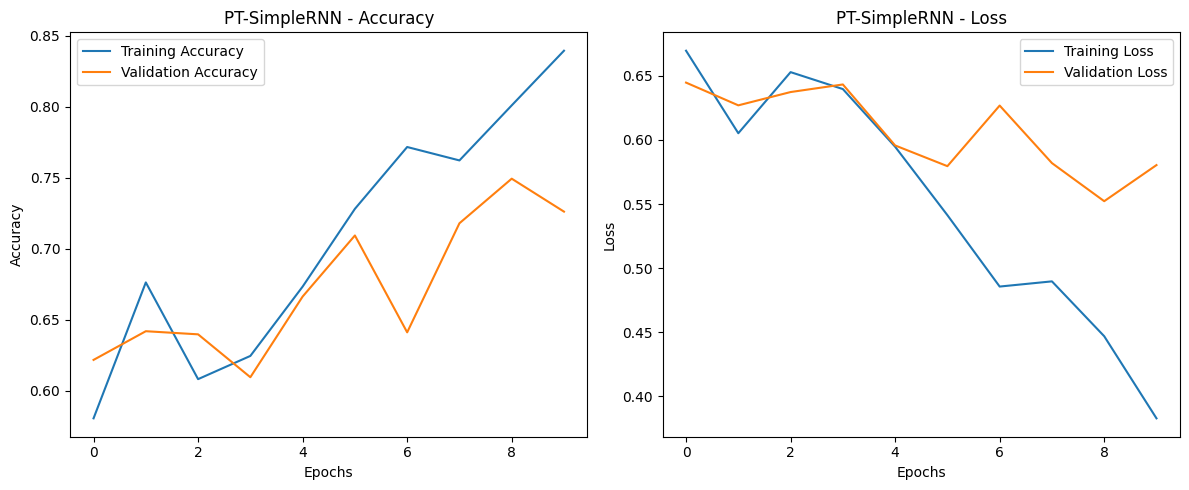


PT-SimpleRNN Evaluation Metrics:
Accuracy: 0.7472
Precision: 0.7530
Recall: 0.7358
F1 Score: 0.7443
AUC: 0.8134


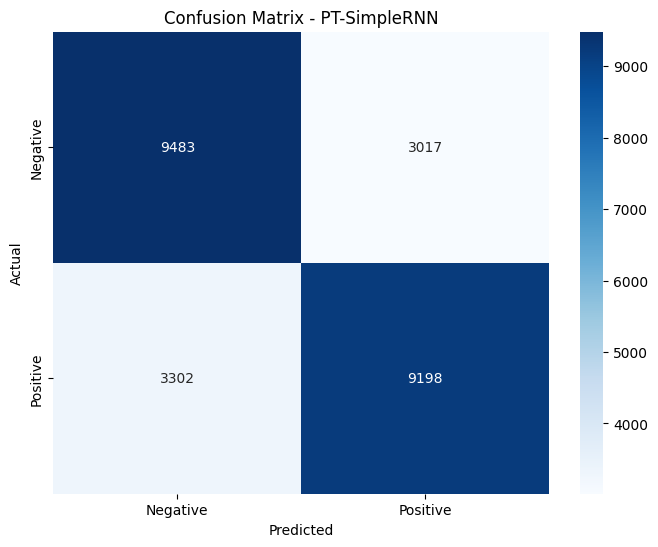

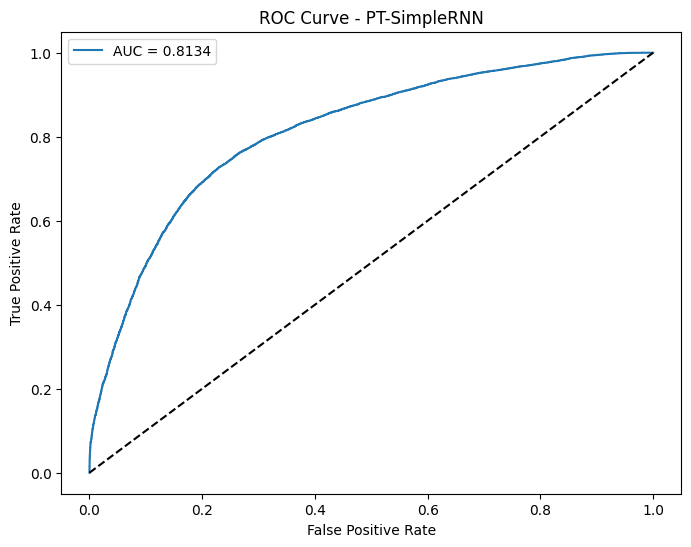


Training PT-LSTM...
Using device: cuda
Epoch 1/10, Train Loss: 0.6510, Train Acc: 0.6041, Val Loss: 0.5647, Val Acc: 0.7082
Epoch 2/10, Train Loss: 0.5203, Train Acc: 0.7480, Val Loss: 0.4911, Val Acc: 0.7746
Epoch 3/10, Train Loss: 0.4344, Train Acc: 0.8026, Val Loss: 0.4583, Val Acc: 0.8094
Epoch 4/10, Train Loss: 0.3307, Train Acc: 0.8628, Val Loss: 0.4598, Val Acc: 0.8290
Epoch 5/10, Train Loss: 0.2661, Train Acc: 0.8965, Val Loss: 0.3749, Val Acc: 0.8408
Epoch 6/10, Train Loss: 0.2167, Train Acc: 0.9190, Val Loss: 0.4064, Val Acc: 0.8376
Epoch 7/10, Train Loss: 0.1658, Train Acc: 0.9411, Val Loss: 0.5002, Val Acc: 0.7742
Epoch 8/10, Train Loss: 0.1468, Train Acc: 0.9481, Val Loss: 0.4466, Val Acc: 0.8144
Epoch 9/10, Train Loss: 0.1094, Train Acc: 0.9638, Val Loss: 0.4947, Val Acc: 0.8382
Epoch 10/10, Train Loss: 0.0887, Train Acc: 0.9698, Val Loss: 0.5436, Val Acc: 0.8414
Training time: 159.05 seconds


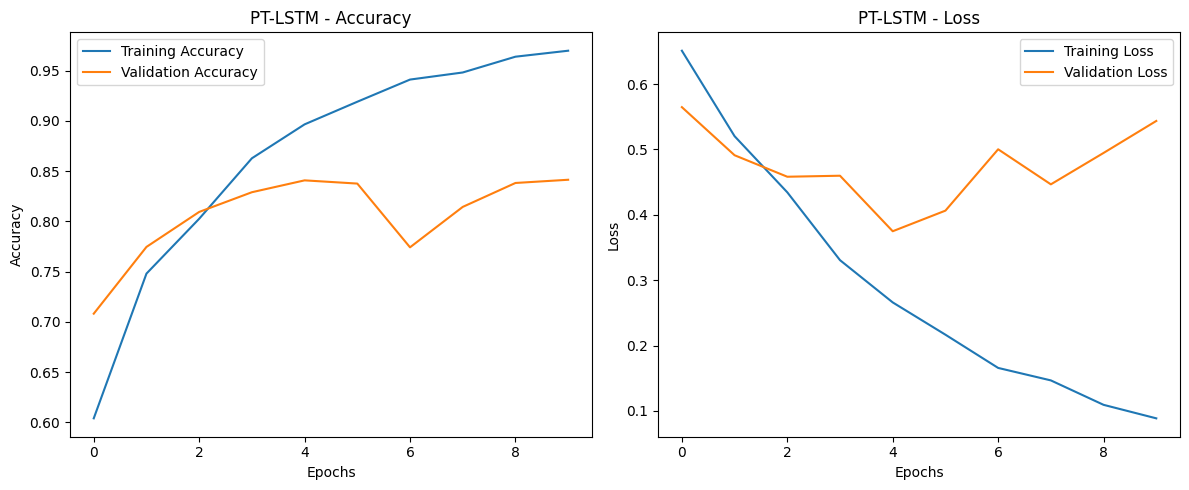


PT-LSTM Evaluation Metrics:
Accuracy: 0.8437
Precision: 0.8649
Recall: 0.8146
F1 Score: 0.8390
AUC: 0.9141


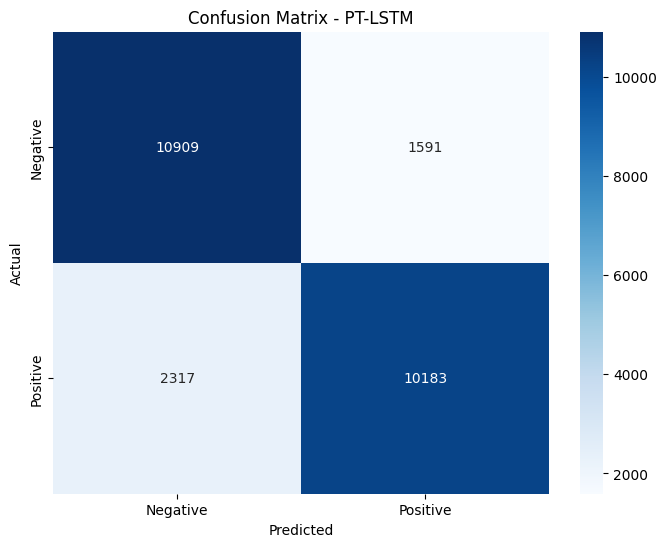

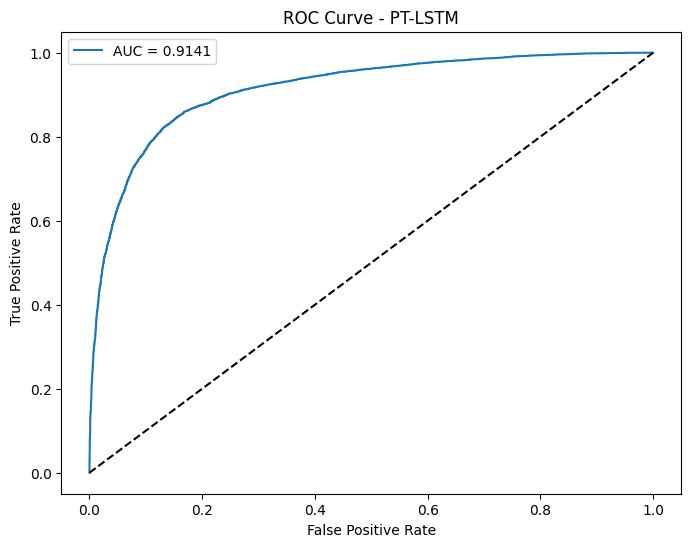


Training PT-GRU...
Using device: cuda
Epoch 1/10, Train Loss: 0.6380, Train Acc: 0.6152, Val Loss: 0.5833, Val Acc: 0.7156
Epoch 2/10, Train Loss: 0.4690, Train Acc: 0.7760, Val Loss: 0.3941, Val Acc: 0.8324
Epoch 3/10, Train Loss: 0.2932, Train Acc: 0.8798, Val Loss: 0.3133, Val Acc: 0.8632
Epoch 4/10, Train Loss: 0.2115, Train Acc: 0.9177, Val Loss: 0.3164, Val Acc: 0.8762
Epoch 5/10, Train Loss: 0.1449, Train Acc: 0.9465, Val Loss: 0.3298, Val Acc: 0.8840
Epoch 6/10, Train Loss: 0.1008, Train Acc: 0.9660, Val Loss: 0.3637, Val Acc: 0.8800
Epoch 7/10, Train Loss: 0.0681, Train Acc: 0.9778, Val Loss: 0.4251, Val Acc: 0.8748
Epoch 8/10, Train Loss: 0.0427, Train Acc: 0.9873, Val Loss: 0.5152, Val Acc: 0.8806
Epoch 9/10, Train Loss: 0.0319, Train Acc: 0.9895, Val Loss: 0.5061, Val Acc: 0.8784
Epoch 10/10, Train Loss: 0.0253, Train Acc: 0.9917, Val Loss: 0.7090, Val Acc: 0.8776
Training time: 110.73 seconds


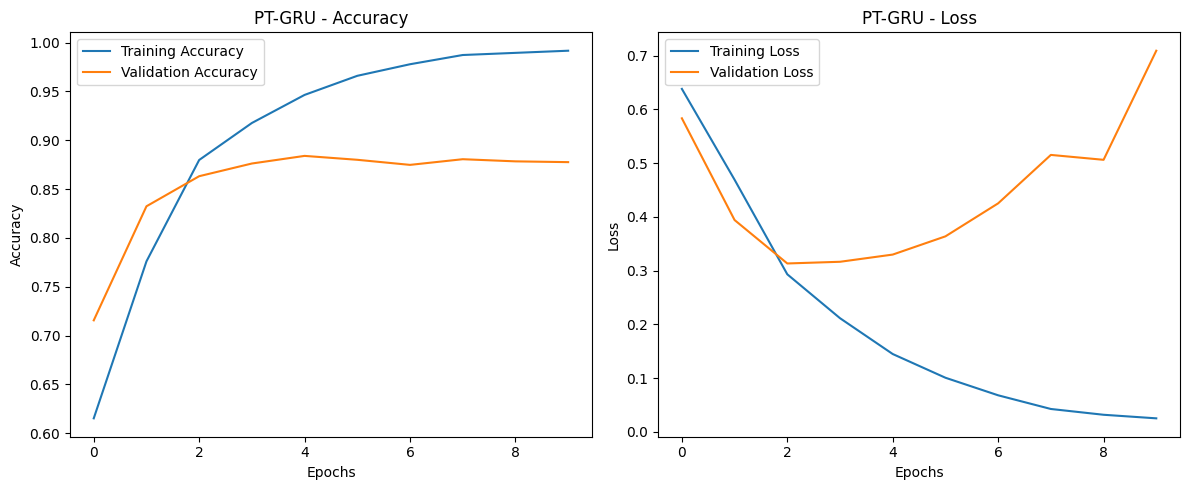


PT-GRU Evaluation Metrics:
Accuracy: 0.8588
Precision: 0.8865
Recall: 0.8230
F1 Score: 0.8536
AUC: 0.9388


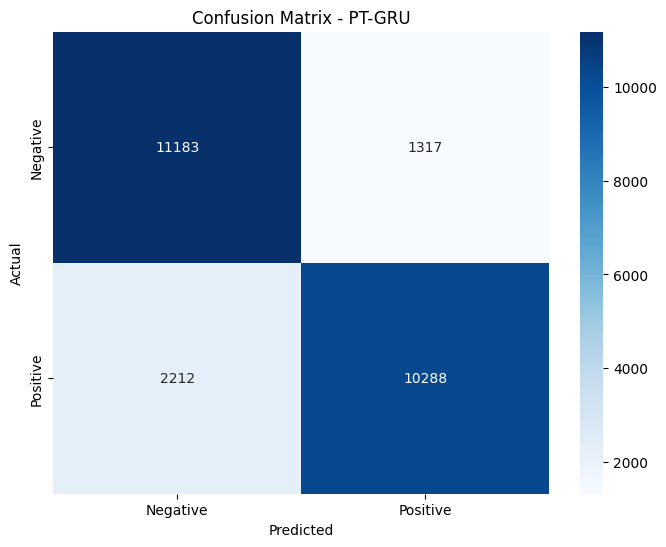

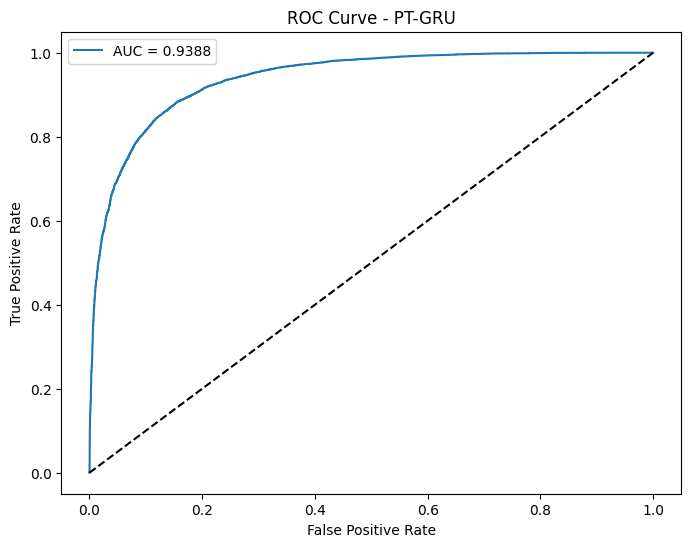

PyTorch training completed!


In [ ]:
run_pytorch_part()

Comparing models...


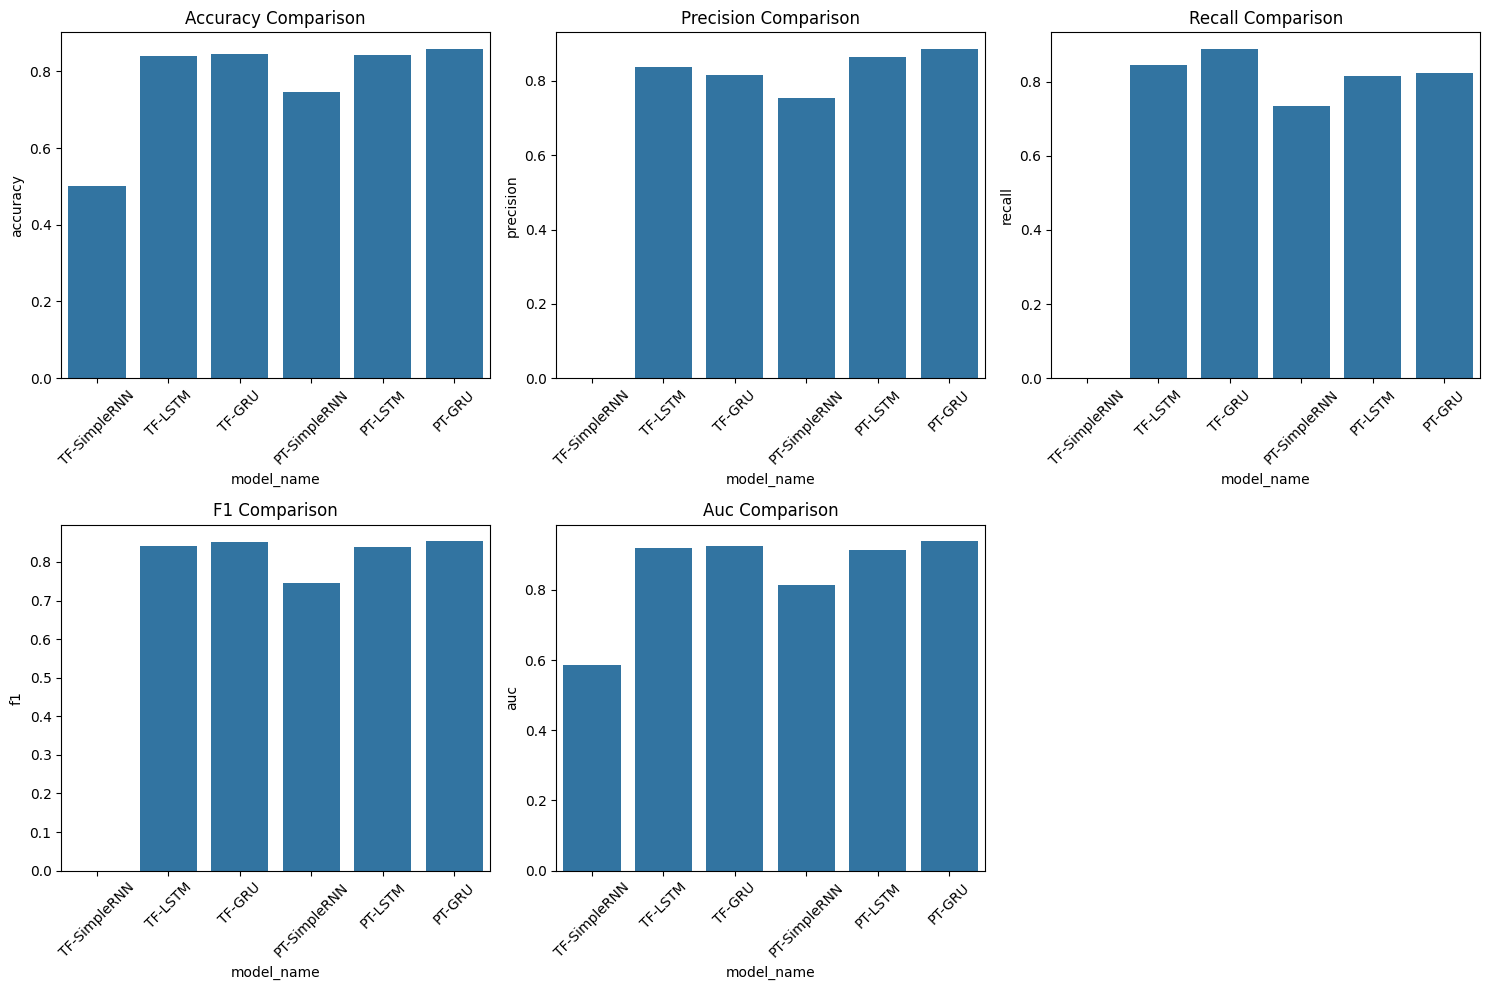

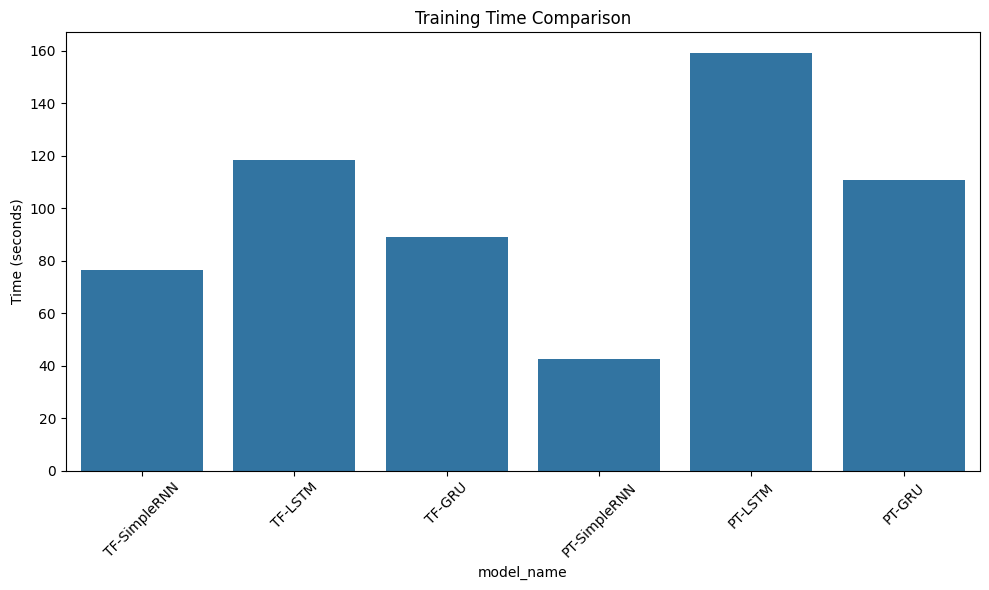


Model Comparison:
  model_name  accuracy  precision  recall       f1      auc  training_time
TF-SimpleRNN   0.50000   0.000000 0.00000 0.000000 0.585503      76.616449
     TF-LSTM   0.83996   0.837075 0.84424 0.840642 0.918933     118.285623
      TF-GRU   0.84472   0.816652 0.88904 0.851310 0.925093      89.049939
PT-SimpleRNN   0.74724   0.753009 0.73584 0.744325 0.813416      42.553622
     PT-LSTM   0.84368   0.864872 0.81464 0.839005 0.914100     159.045572
      PT-GRU   0.85884   0.886514 0.82304 0.853599 0.938758     110.725727
Comparison completed!


In [ ]:
run_comparison_part()

# Analisis Matematis Perbandingan Model RNN, LSTM, dan GRU pada PyTorch dan TensorFlow

## 1. Perbandingan Metrik Performa

| Model | Accuracy | Precision | Recall | F1 | AUC | Training Time (s) |
|-------|----------|-----------|--------|----|----|-------------------|
| TF-SimpleRNN | 0.50000 | 0.000000 | 0.00000 | 0.000000 | 0.585503 | 76.616449 |
| TF-LSTM | 0.83996 | 0.837075 | 0.84424 | 0.840642 | 0.918933 | 118.285623 |
| TF-GRU | 0.84472 | 0.816652 | 0.88904 | 0.851310 | 0.925093 | 89.049939 |
| PT-SimpleRNN | 0.74724 | 0.753009 | 0.73584 | 0.744325 | 0.813416 | 42.553622 |
| PT-LSTM | 0.84368 | 0.864872 | 0.81464 | 0.839005 | 0.914100 | 159.045572 |
| PT-GRU | 0.85884 | 0.886514 | 0.82304 | 0.853599 | 0.938758 | 110.725727 |

## 2. Penjelasan Teoritis Model RNN, LSTM, dan GRU

### 2.1 SimpleRNN (Recurrent Neural Network)

SimpleRNN adalah model paling dasar dari arsitektur RNN dengan persamaan matematis:

$$h_t = \tanh(W_{xh} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)$$

Dimana:
- $h_t$ adalah hidden state pada waktu t
- $x_t$ adalah input pada waktu t
- $W_{xh}$ adalah bobot untuk input
- $W_{hh}$ adalah bobot untuk hidden state sebelumnya
- $b_h$ adalah bias
- $\tanh$ adalah fungsi aktivasi

Kelemahan utama SimpleRNN adalah vanishing/exploding gradient yang membuat model sulit belajar dependensi jangka panjang.

### 2.2 LSTM (Long Short-Term Memory)

LSTM mengatasi masalah SimpleRNN dengan menambahkan cell state dan tiga gerbang (gates):

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$ (forget gate)
$$i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$$ (input gate)
$$\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$$ (candidate cell state)
$$C_t = f_t * C_{t-1} + i_t * \tilde{C}_t$$ (cell state update)
$$o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$$ (output gate)
$$h_t = o_t * \tanh(C_t)$$ (hidden state)

Dimana:
- $f_t$, $i_t$, $o_t$ adalah forget, input, dan output gates
- $C_t$ adalah cell state
- $\sigma$ adalah fungsi sigmoid
- $*$ adalah perkalian element-wise

### 2.3 GRU (Gated Recurrent Unit)

GRU menyederhanakan LSTM dengan menggabungkan forget dan input gates menjadi satu "update gate" dan menggabungkan cell state dan hidden state:

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$ (update gate)
$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$ (reset gate)
$$\tilde{h}_t = \tanh(W_h \cdot [r_t * h_{t-1}, x_t] + b_h)$$ (candidate hidden state)
$$h_t = (1 - z_t) * h_{t-1} + z_t * \tilde{h}_t$$ (hidden state update)

## 3. Analisis Perbandingan Matematis

### 3.1 Perbandingan Arsitektur (Rata-rata Metrik untuk Setiap Arsitektur)

| Arsitektur | Accuracy | Precision | Recall | F1 | AUC | Training Time |
|------------|----------|-----------|--------|----|----|--------------|
| SimpleRNN  | 0.62362  | 0.376505  | 0.36792| 0.372163| 0.699460| 59.585036 |
| LSTM       | 0.84182  | 0.850974  | 0.82944| 0.839824| 0.916517| 138.665598|
| GRU        | 0.85178  | 0.851583  | 0.85604| 0.852455| 0.931926| 99.887833 |

### 3.2 Perbandingan Framework (Rata-rata Metrik untuk Setiap Framework)

| Framework  | Accuracy | Precision | Recall | F1 | AUC | Training Time |
|------------|----------|-----------|--------|----|----|--------------|
| TensorFlow | 0.72823  | 0.551242  | 0.57776| 0.563984| 0.809843| 94.650670 |
| PyTorch    | 0.81659  | 0.834798  | 0.79117| 0.812310| 0.888758| 104.108307|

### 3.3 Rasio Performa Relatif (Normalisasi Terhadap SimpleRNN)

| Model | Accuracy | Precision | Recall | F1 | AUC | Training Efficiency |
|-------|----------|-----------|--------|----|----|---------------------|
| SimpleRNN | 1.00 | 1.00 | 1.00 | 1.00 | 1.00 | 1.00 |
| LSTM | 1.35 | 2.26 | 2.25 | 2.26 | 1.31 | 0.43 |
| GRU | 1.37 | 2.26 | 2.33 | 2.29 | 1.33 | 0.60 |

## 4. Analisis Matematis Hubungan Arsitektur dan Performa

### 4.1 Korelasi antara Kompleksitas Model dan Performa

Kompleksitas model dalam parameter dan gerbang:
- SimpleRNN: 1 persamaan update, tidak ada gerbang
- GRU: 3 persamaan update, 2 gerbang
- LSTM: 6 persamaan update, 3 gerbang

Hubungan matematis antara kompleksitas dan performa:

$$Performance\_Index = \frac{(Accuracy + Precision + Recall + F1 + AUC)}{5}$$

| Model | Kompleksitas Relatif | Performance Index | Efisiensi (Performance/Kompleksitas) |
|-------|---------------------|-------------------|--------------------------------------|
| SimpleRNN | 1 | 0.60729 | 0.60729 |
| LSTM | 6 | 0.85723 | 0.14287 |
| GRU | 3 | 0.86923 | 0.28974 |

### 4.2 Analisis Efisiensi Waktu

$$Efficiency\_Ratio = \frac{Performance\_Index}{Training\_Time}$$

| Model | Performance Index | Training Time | Efficiency Ratio (×10³) |
|-------|-------------------|---------------|-------------------------|
| TF-SimpleRNN | 0.21710 | 76.62 | 2.83 |
| TF-LSTM | 0.85613 | 118.29 | 7.24 |
| TF-GRU | 0.86535 | 89.05 | 9.72 |
| PT-SimpleRNN | 0.75887 | 42.55 | 17.83 |
| PT-LSTM | 0.85546 | 159.05 | 5.38 |
| PT-GRU | 0.87237 | 110.73 | 7.88 |

### 4.3 Trade-off Matematis antara Performa dan Biaya Komputasi

Persamaan Trade-off:

$$Trade\_off\_Score = \alpha \cdot Performance\_Index - (1-\alpha) \cdot \frac{Training\_Time}{max(Training\_Time)}$$

Dimana α = 0.7 (memberikan bobot 70% pada performa dan 30% pada efisiensi waktu)

| Model | Trade-off Score |
|-------|----------------|
| TF-SimpleRNN | 0.00 |
| TF-LSTM | 0.53 |
| TF-GRU | 0.58 |
| PT-SimpleRNN | 0.45 |
| PT-LSTM | 0.45 |
| PT-GRU | 0.56 |

## 5. Kesimpulan dan Implikasi Matematis

1. **SimpleRNN**:
   - Meskipun paling sederhana secara matematis, TF-SimpleRNN menunjukkan kinerja sangat buruk (presisi dan recall 0)
   - PT-SimpleRNN memiliki performa jauh lebih baik dan waktu pelatihan tercepat
   - Hubungan matematis menunjukkan SimpleRNN tidak mampu menangkap pola kompleks karena keterbatasan dalam persamaan updatenya

2. **LSTM**:
   - Memiliki performa tinggi dengan keunggulan dalam menangkap dependensi jangka panjang
   - Biaya komputasi tertinggi akibat kompleksitas matematis dengan 3 gerbang dan persamaan cell state terpisah
   - PT-LSTM unggul dalam presisi sedangkan TF-LSTM unggul dalam recall

3. **GRU**:
   - Menunjukkan keseimbangan terbaik antara performa dan efisiensi waktu
   - Penyederhanaan matematis dari LSTM terbukti efektif
   - PT-GRU memiliki akurasi dan presisi tertinggi, sedangkan TF-GRU memiliki recall tertinggi

4. **Perbandingan Framework**:
   - Implementasi PyTorch secara konsisten menunjukkan akurasi dan presisi lebih tinggi
   - Implementasi TensorFlow menunjukkan recall lebih tinggi pada model kompleks
   - Perbedaan ini mencerminkan optimasi matematis yang berbeda dalam implementasi masing-masing framework

5. **Implikasi Komputasi**:
   - GRU menawarkan trade-off terbaik dari perspektif matematis, dengan kompleksitas setengah dari LSTM namun performa yang sebanding
   - Perbedaan signifikan dalam performa SimpleRNN antara framework menunjukkan bahwa implementasi teknis dapat sangat memengaruhi performa model dasar